### Importar librerías y series de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
#importar datos y librerias
from datetime import datetime
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
from scipy.stats import boxcox
from scipy import special
from scipy.ndimage.interpolation import shift

In [3]:
# Modelos regresivos
from xgboost import XGBRegressor 
from sklearn.linear_model import LinearRegression

In [4]:
#Abrir librerias necesarias
general = pd.read_excel(r'.\Data2.xlsx').dropna(axis = 1)
general = general.set_index("fecha")
festivos=pd.read_excel("Festivos.xlsx")
festivos2=pd.read_excel("Festivos2.xlsx")

### Establecer las funciones a utilizar

In [5]:
def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    Combinacion = pd.DataFrame(); d1 = pd.DataFrame()
    for i in data2.columns:
        d1 = data1.multiply(data2[f"{i}"] , axis="index")
        d1.columns = [f'{i}_{j}' for j in data1.columns]
        Combinacion = pd.concat([Combinacion, d1], axis = 1)
    return Combinacion

In [6]:
def regresion_linear(X:'variables para regresion',y:'datos'):
    global model
    model.fit(X, y)
    coefficients=model.coef_
    return model.predict(X)

In [7]:
def comparacion(real,pred):
    comparacion=pd.DataFrame(columns=['real','prediccion','error'])
    comparacion.real=real
    comparacion.prediccion=pred
    comparacion.error=np.abs((comparacion.real.values-comparacion.prediccion)/comparacion.real)*100
    return comparacion

### Hacer variables dummies

PCA o Árboles de desciciones para sber que regresores utilizar

In [8]:
def y(n):
    final= general.MWh.tail(n)
    return final

In [17]:
def Dumm():
    te = np.arange(1, len(general.MWh)+1)
    Dum = pd.DataFrame(index = general.index)
    
    for col in festivos.columns:
        Dum[f"{col}"] = general.index.isin(festivos[f"{col}"])
        Dum[col] = Dum[col].replace([False, True],[0, 1])
        clean=Dum[col].values
        Dum[col]=Dum[col]+shift(clean, 1, cval=0)*.2
        Dum[col]=Dum[col]+shift(clean, -1, cval=0)*.2
        Dum[col]=Dum[col]+shift(clean, 2, cval=0)*.05
        Dum[col]=Dum[col]+shift(clean, -2, cval=0)*.05
    Dum = Dum.replace([1],[0.5])
    
    for col in festivos2.columns:
        Dum[col] = general.index.isin(festivos2[col])
    Dum = Dum.replace([False, True],[0, 1])
    
    Dum['Month'] = general.index.month
    Dum['weekday'] = general.index.weekday
    
    Dum["lluvia"] = general.Lluvia/general.Lluvia.max()
    Dum["Velocidad"] = general["Velocidad viento"]/general["Velocidad viento"].max()
    Dum["Nubosidad"] = general.Nubosidad/general.Nubosidad.max()
    Dum["min"] = general["mín"]/general["mín"].max()
    Dum["max"] = general["max"]/general["max"].max()
     
    Dum = pd.get_dummies(Dum, columns=["weekday", "Month"], prefix=["dw", "mes"], drop_first=True)
    Dum["tiempo"] = te/np.max(te)
    
    return Dum

In [27]:
Dumm()["mes_2"]

fecha
2004-01-01    0
2004-01-02    0
2004-01-03    0
2004-01-04    0
2004-01-05    0
             ..
2020-02-14    1
2020-02-15    1
2020-02-16    1
2020-02-17    1
2020-02-18    1
Name: mes_2, Length: 5893, dtype: uint8

In [28]:
def Observar_descomposicion():
    part=general.MWh.tail(200)
    result = seasonal_decompose(part, model='multiplicative')
    plt.figure(figsize=(20, 5))
    plt.plot(result.seasonal, c = 'red')

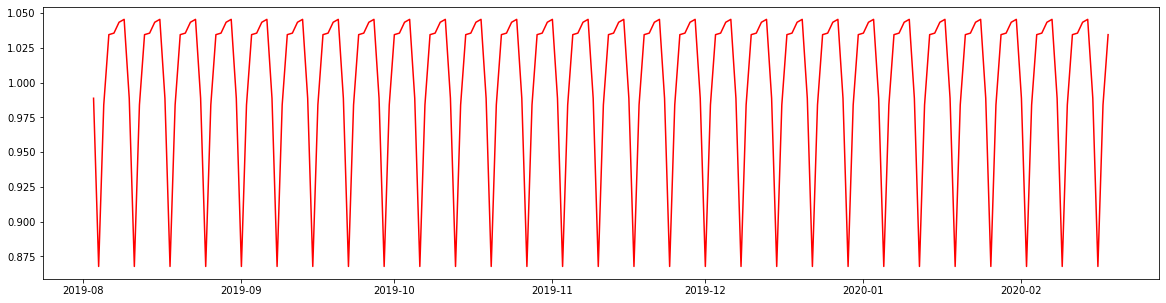

In [29]:
Observar_descomposicion();

In [30]:
def peak():
    part = general.MWh
    result = seasonal_decompose(part, model="multiplicative").seasonal.reset_index(drop = True)
    f, asd = signal.periodogram(result)
    peaks, _ = find_peaks(asd, height=0)
#     plt.plot(1/f, asd)
#     plt.xlim(0, 10)
    return 1/(f[peaks])

In [31]:
peak()

array([6.99881235, 3.49940618, 2.33293745])

In [32]:
def sen_cos():
    t = np.arange(1, len(general.MWh)+1)
    Tiempo = pd.DataFrame(t, columns = ['te'])
    Tiempo["one"] = 1
    picos = peak()
    for ar in picos:
        Tiempo[f'sen_{ar:.2f}']=np.abs(np.sin(((np.pi)/ar)*t))
        Tiempo[f'cos_{ar:.2f}']=np.abs(np.cos(((np.pi)/ar)*t))
    return Tiempo 

In [33]:
sen_cos()

,te,one,sen_7.00,cos_7.00,sen_3.50,cos_3.50,sen_2.33,cos_2.33
0,1,1,4.339524e-01,0.900936,7.819264e-01,0.623371,9.749787e-01,0.222298
1,2,1,7.819264e-01,0.623371,9.748601e-01,0.222818,4.334720e-01,0.901167
2,3,1,9.749787e-01,0.222298,4.334720e-01,0.901167,7.822587e-01,0.622954
3,4,1,9.748601e-01,0.222818,4.344326e-01,0.900704,7.812614e-01,0.624204
4,5,1,7.815940e-01,0.623787,9.750971e-01,0.221778,4.349127e-01,0.900473
...,...,...,...,...,...,...,...,...
5888,5889,1,9.748601e-01,0.222818,4.344326e-01,0.900704,7.812614e-01,0.624204
5889,5890,1,9.749787e-01,0.222298,4.334720e-01,0.901167,7.822587e-01,0.622954
5890,5891,1,7.819264e-01,0.623371,9.748601e-01,0.222818,4.334720e-01,0.901167
5891,5892,1,4.339524e-01,0.900936,7.819264e-01,0.623371,9.749787e-01,0.222298


In [34]:
def kr_reg_uno(n):
    #Primer kronecker
    Dum = Dumm(); Tiempo = sen_cos()
    Combinacion1 = kronecker(Dum, Tiempo)
    Combinacion = pd.concat([Combinacion1, Dum, Tiempo], axis = 1)
    #Modelo 
    model = LinearRegression(n_jobs = -1).fit(Combinacion[:-n], general.MWh.values[:-n])
    prediction = model.predict(Combinacion[:-n])
    comp=comparacion(general.MWh.values[:-n],prediction)
    return comp

Adaboost

In [53]:
res = kr_reg_uno(7);

2.3436194575638276

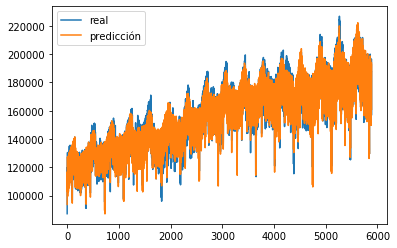

In [54]:
plt.plot(res.real, label = "real")
plt.plot(res.prediccion, label = "predicción")
plt.legend()
res.error.mean()

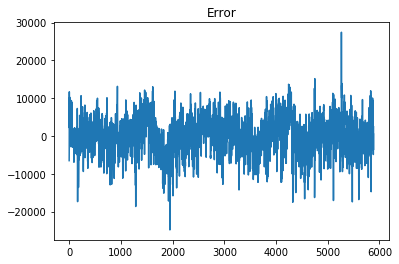

In [55]:
plt.title("Error")
plt.plot(res.real - res.prediccion);

In [56]:
def resta_dkg(n):
    comp = kr_reg_uno(n)
    camp = comp.real - comp.prediccion
    f, asd = signal.periodogram(camp)
    peaks, _ = find_peaks(asd, height=0)
    picos = pd.DataFrame(_['peak_heights'], 1/(f[peaks]), columns=["altura_pk"])
    picos = picos.sort_values(by="altura_pk",ascending=False).reset_index().drop([0,1]).head(12)
    picos.columns = ["periodo", "altura"]
    return picos

In [57]:
resta_dkg(7);

In [58]:
def kron2(n):
    sencos = pd.DataFrame(); sencos1 = sen_cos(); per = resta_dkg(n); D = Dumm()
    t=np.arange(1,len(general.MWh)+1)
    for i  in  per.periodo:
        sencos[f"sen_{i:.2f}"] = np.abs(np.sin(((2*np.pi)/i)*t))
        sencos[f"cos_{i:.2f}"] = np.abs(np.cos(((2*np.pi)/i)*t))
    sencos['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
    sencos['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
    sencos['sen1']=np.abs(np.sin(((2*np.pi)/365)*t))
    sencos['cos1']=np.abs(np.cos(((2*np.pi)/365)*t))
    sencos['sen2']=np.abs(np.sin(((2*np.pi)/28)*t))
    sencos['cos2']=np.abs(np.cos(((2*np.pi)/28)*t))
    
    SC = pd.concat([sencos, sencos1], axis = 1)
    
    kron = kronecker(SC, D)
    kron1 = pd.concat([kron, sencos1], axis = 1)
    return kron1

In [59]:
def regr_2d(n):
    
    K_train, K_test, y_train, y_test = train_test_split(kron2(n), general.MWh, test_size = n, shuffle = False)
    print(K_train.shape)
    model = LinearRegression(n_jobs = -1).fit(K_train, y_train)
    predict = model.predict(K_train)
    plt.plot(y_train.reset_index(drop = True))
    plt.plot(predict)
    return y_train, predict

(5886, 1718)


1.428775171165685

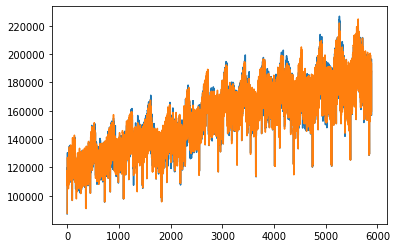

In [60]:
y_y, predo = regr_2d(7);
comparacion(y_y, predo).error.mean(axis = 0)

residual

histograma

arima

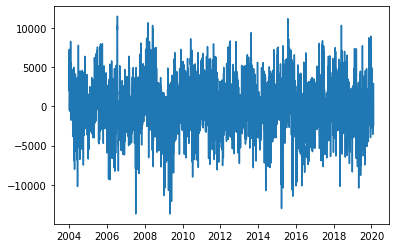

In [61]:
plt.plot(comparacion(y_y, predo).real - comparacion(y_y, predo).prediccion);

In [62]:
ovo = comparacion(y_y, predo).real - comparacion(y_y, predo).prediccion

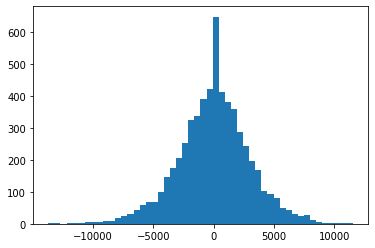

In [63]:
plt.hist(ovo,bins=50)
plt.show()

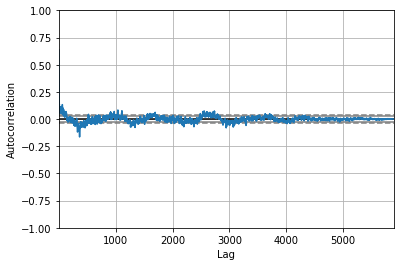

In [64]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ovo)

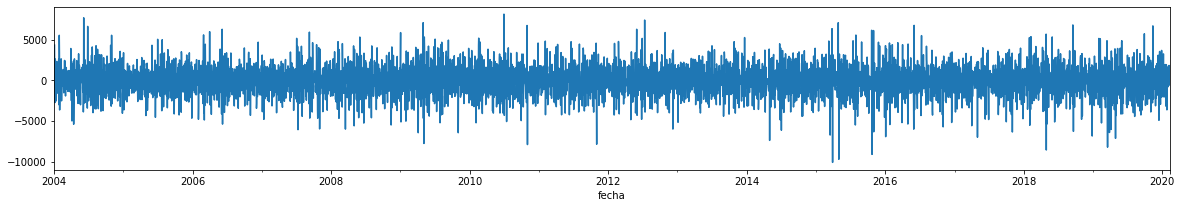

In [65]:
plt.figure(figsize = (20, 3))
seasonal_decompose(ovo, model='additive').resid.plot();

In [67]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(ovo,exog=Dumm()[0:-7],start_p=1, start_q=1, max_p=7, max_q=7, max_d=7,
                     trace=True, error_action='ignore', suppress_warnings=True, stepwise=True,m=1,
                    seasonal=False,Stationary=True, n_jobs = -1)

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:303: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=107755.429, BIC=107782.150, Time=0.877 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=110871.775, BIC=110885.136, Time=0.163 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=107831.738, BIC=107851.779, Time=0.354 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=108878.142, BIC=108898.183, Time=0.756 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=110869.775, BIC=110876.456, Time=0.095 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=107727.191, BIC=107760.592, Time=2.870 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=107774.320, BIC=107801.041, Time=0.459 seconds
Fit ARIMA: (3, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=107728.791, BIC=107768.873, Time=3.542 seconds
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=107728.516, BIC=107768.598, Time=3.343 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (con

In [68]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5886
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -53858.530
Date:                Sun, 23 Feb 2020   AIC                         107727.059
Time:                        13:19:55   BIC                         107760.461
Sample:                             0   HQIC                        107738.670
                               - 5886                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.0074     19.277     -0.052      0.958     -38.789      36.775
ar.L1          0.8194      0.014     56.753      0.000       0.791       0.848
ma.L1         -0.2601      0.019    -13.946      0.000      -0.297      -0.224
ma.L2         -0.0980      0.015     -6.329      0.000      -0.128      -0.068
sigma2      5.189e+06   7.45e+04     69.636      0.000    5.04e+06    5.34e+06
===================================================================================
Ljung-Box (Q):                      169.77   Jarque-Bera (JB):               562.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.26
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [123]:
ovo

fecha
2004-01-01    -434.516553
2004-01-02     590.790658
2004-01-03    2051.180467
2004-01-04    7283.386428
2004-01-05    5434.982440
                 ...     
2020-02-07    -521.971599
2020-02-08      75.660965
2020-02-09   -2513.298496
2020-02-10    1185.331895
2020-02-11    2907.765561
Length: 5886, dtype: float64

In [140]:
doc = Dumm()[0:-7]

In [141]:
doc.index = ovo.index

In [143]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
bronc = SARIMAX(ovo, exog=doc, order=(1, 0, 2), seasonal_order=(0, 0, 0, 7), trend=None, measurement_error=False, time_varying_regression=False)

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [145]:
prediction = bronc.fit().predict(start=0, end=len(ovo)-1, exog=doc, enforce_invertibility=False, enforce_stationarity=False)

In [150]:
prediction[1:]

2004-01-02    -275.882458
2004-01-03     294.123862
2004-01-04    1146.382482
2004-01-05    4204.940020
2004-01-06    3532.670076
                 ...     
2020-02-07     941.964447
2020-02-08    -193.327044
2020-02-09     135.554534
2020-02-10   -1396.628881
2020-02-11     559.255164
Freq: D, Length: 5885, dtype: float64

In [151]:
ovo

fecha
2004-01-01    -434.516553
2004-01-02     590.790658
2004-01-03    2051.180467
2004-01-04    7283.386428
2004-01-05    5434.982440
                 ...     
2020-02-07    -521.971599
2020-02-08      75.660965
2020-02-09   -2513.298496
2020-02-10    1185.331895
2020-02-11    2907.765561
Length: 5886, dtype: float64

In [153]:
pd.concat([ovo.reset_index(drop = True), prediction[1:].reset_index(drop = True)], axis = 1).iplot()

In [157]:
comparacion(ovo[0:-1], prediction[1:]).error

fecha
2004-01-01           NaN
2004-01-02    146.697160
2004-01-03     85.660752
2004-01-04     84.260309
2004-01-05     22.631948
                 ...    
2020-02-06     90.626043
2020-02-07    280.462778
2020-02-08    355.517551
2020-02-09    105.393491
2020-02-10    217.825976
Name: error, Length: 5885, dtype: float64

C:\Users\alber\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



25964401.368236866

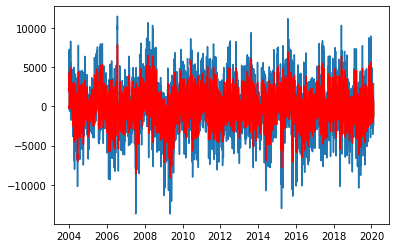

In [154]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(ovo, order=(1,0,2))
results = mod.fit()
plt.plot(ovo)
plt.plot(results.fittedvalues, color='red');
comparacion(ovo[0:-1], results.fittedvalues[1:]).error.mean()

In [87]:
def visualizar_arima__reg():
    
    plt.plot(ovo)
    plt.plot(results.fittedvalues, color='red');
    
    plt.figure(figsize=(10,5))
    plt.plot((general.MWh[0:-7].reset_index(drop=True)).values,label="Reales")
    plt.plot(predo+(results.fittedvalues).reset_index(drop = True),label="Predicción")
    plt.ylabel("demanda en MWh")
    plt.xlabel("días")
    plt.legend()
    #%%obtener mape de regresión
    comp=comparacion((general.MWh[0:-7].reset_index(drop=True)).values,predo+(results.fittedvalues).reset_index(drop = True))
    MAPE=comp.error.mean()
    print("MAPE = ",round(MAPE,4),"%")
    

MAPE =  1.099 %


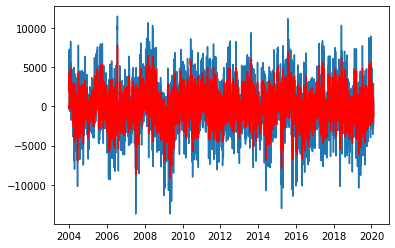

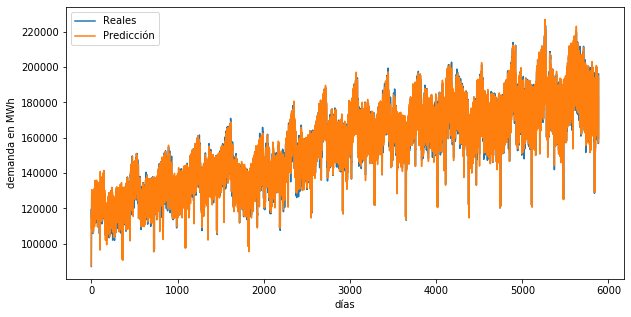

In [111]:
visualizar_arima__reg()

MAPE =  1.0957 %


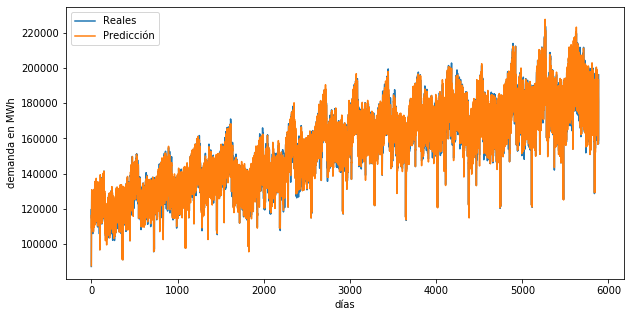

In [195]:
##spatial electric load forecasting
plt.figure(figsize=(10,5))
plt.plot((general.MWh[0:-7].reset_index(drop=True)).values,label="Reales")
plt.plot(predo+(results.fittedvalues).reset_index(drop = True),label="Predicción")
plt.ylabel("demanda en MWh")
plt.xlabel("días")
plt.legend()
#%%obtener mape de regresión
comp=comparacion((general.MWh[0:-7].reset_index(drop=True)).values,predo+(results.fittedvalues).reset_index(drop = True))
MAPE=comp.error.mean()
print("MAPE = ",round(MAPE,4),"%")

In [99]:
results.fittedvalues+predo

fecha
2004-01-01     87647.826579
2004-01-02    111423.939644
2004-01-03    118045.184331
2004-01-04    108398.962913
2004-01-05    123470.884479
                  ...      
2020-02-07    189509.079957
2020-02-08    180545.224023
2020-02-09    159406.327236
2020-02-10    183112.886747
2020-02-11    193717.966925
Length: 5886, dtype: float64

In [109]:
len(ovo), len(results.fittedvalues)

5886

5886

In [108]:
import chart_studio.plotly as ply
import cufflinks as cf
cf.go_offline()
cras = pd.DataFrame(ovo, columns = ["real"])
cras["prediccion"] = results.fittedvalues
cras.iplot(title="Real contra prediccion Arima")

In [107]:
pd.concat([general.MWh[0:-7], results.fittedvalues+predo], axis = 1).iplot()

In [105]:
cras

fecha
2004-01-01     87213.310000
2004-01-02    112290.738000
2004-01-03    119804.252000
2004-01-04    114518.220000
2004-01-05    124693.228000
                  ...      
2020-02-14    198104.110000
2020-02-15    197219.405000
2020-02-16    187374.431000
2020-02-17    165175.599136
2020-02-18    192313.544008
Name: MWh, Length: 5893, dtype: float64

In [ ]:
sencos_test=sencos[n:]
sencos_train=sencos[0:n]
Dum_test=Dum[n:]
Dum_train=Dum[0:n]
Combinacion=kronecker(sencos_train,Dum_train)

model = LinearRegression()
prediction=regresion_linear(Combinacion,general.MWh.values[0:n])

### MAPE de la regresion

plt.figure(figsize=(10,5))
plt.plot(onlyMWh.MWh[0:n].values,label ="Datos")
plt.plot(prediction,label="Predicción")
plt.ylabel("demanda en MWh")
plt.xlabel("días")
plt.legend()
plt.show()
#%%obtener mape de regresión
comp=comparacion(onlyMWh.MWh.values[:n],prediction)
MAPE=comp.error.mean()
print("MAPE = ",round(MAPE,4),"%")

In [101]:
n=-14
final=general.MWh.tail(-n)

In [103]:
onlyMWh=pd.DataFrame(general.MWh)
general['Month'] = general.index.month
general['Weekday_Name'] = general.index.weekday

In [104]:
# dates = general.index
dummies = pd.get_dummies(general['Weekday_Name'], prefix="dw", drop_first = True)
dummies2 = pd.get_dummies(general['Month'], prefix="mes", drop_first = True)
Dum=pd.DataFrame(dummies.join(dummies2))


Dum = Dum.reset_index(drop = True)

Dum["tiempo"]= np.arange(1,len(onlyMWh)+1); Dum["ones"]=1

In [105]:
for col in special_days.columns:
    Dum[col] = general.index.isin(special_days[col])
Dum = Dum.replace([False, True],[0, 1])

### Observar descomposición

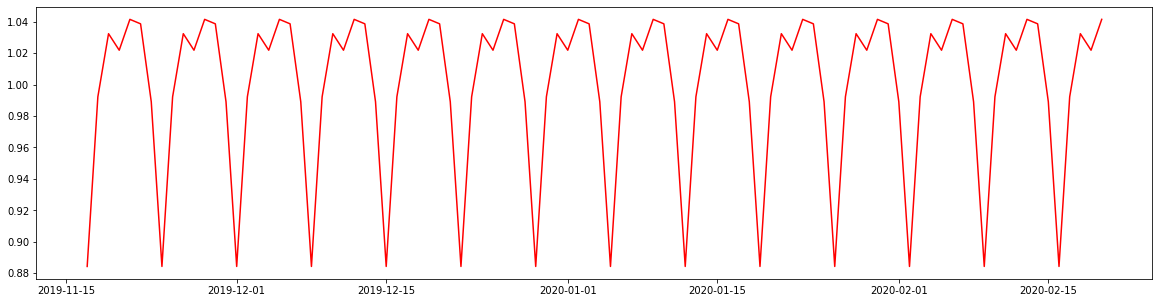

In [176]:
part=general.MWh.tail(96)
result = seasonal_decompose(part, model='multiplicative')
plt.figure(figsize=(20, 5))
plt.plot(result.seasonal, c = 'red');

Al ver la decomposición, se puede ver por la forma que fourier debe estblecerse en senos y cosenos absolutos, para que se parezca a la estacionalidad de la serie. Se agrega a las variables dummies esta estacionalidad semanal, que parece ser fundamental en los datos

### Detectar efecto de las variables dummies

In [107]:
def peak(part):
    result = seasonal_decompose(part, model="multiplicative").seasonal.reset_index(drop = True)
    f, asd = signal.periodogram(result)
    peaks, _ = find_peaks(asd, height=0)
    return peaks

In [108]:
peak(part)

array([14, 27, 41, 47], dtype=int64)

In [198]:
t = np.arange(1,len(onlyMWh)+1)
Tiempo=pd.DataFrame(t, columns = ['te'])
Tiempo["one"] = 1
picos = peak(part)
for ar in picos:
    Tiempo[f'sen_{ar}']=np.abs(np.sin(((np.pi)/ar)*t))
    Tiempo[f'cos_{ar}']=np.abs(np.cos(((np.pi)/ar)*t))

#Primer kronecker
Combinacion = kronecker(Dum, Tiempo)

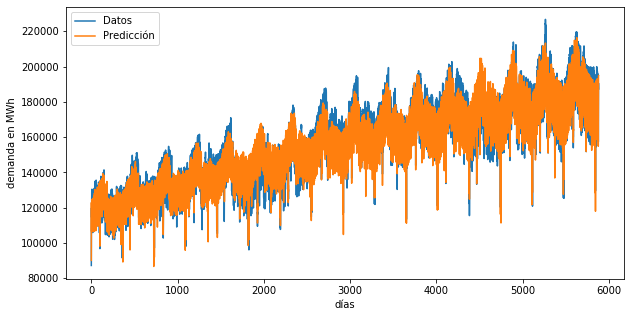

MAPE =  3.147 %


In [199]:
model = LinearRegression(n_jobs = -1)
prediction=regresion_linear(Combinacion[:n],general.MWh.values[:n])
plt.figure(figsize=(10,5))
plt.plot(onlyMWh.MWh.values[:n],label ="Datos")
plt.plot(prediction,label="Predicción")
plt.ylabel("demanda en MWh")
plt.xlabel("días")
plt.legend()
#plt.axis([1630,1650,120000,160000])
plt.show()
comp=comparacion(onlyMWh.MWh.values[:n],prediction)
MAPE=comp.error.mean()
print("MAPE = ",round(MAPE,4),"%")

### Obtener error de datos con variables dummies vs datos reales

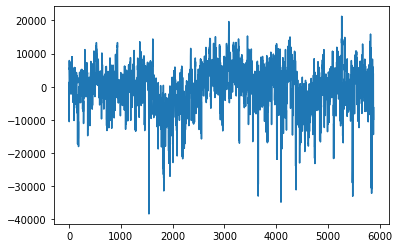

In [111]:
Tabla=pd.DataFrame(columns=['regresion','datos','resta'])
Tabla["regresion"]=prediction
Tabla["datos"]=onlyMWh.MWh.values[:n]
Tabla["resta"]=Tabla.datos-Tabla.regresion
plt.plot(Tabla.resta)
plt.show()

### Establecer las frecuencias que se debe considerar en la serie de fourier

C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


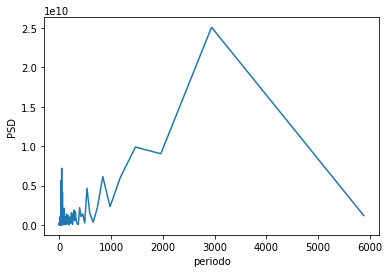

In [112]:
f, Pxx_den = signal.periodogram(Tabla.resta, 1)
plt.plot(1/f, Pxx_den)
plt.xlabel('periodo')
plt.ylabel('PSD')
plt.show()

In [113]:
top_50_periods = {}
# get indices for 3 highest Pxx values
top50_freq_indices = np.flip(np.argsort(Pxx_den), 0)[2:12]

freqs = f[top50_freq_indices]
power = Pxx_den[top50_freq_indices]
periods = 1 / np.array(freqs)
matrix=pd.DataFrame(columns=["power","periods"])
matrix.power=power
matrix.periods=periods
print(matrix)

          power      periods
0  9.034272e+09  1960.333333
1  7.194645e+09    45.589147
2  6.141922e+09   840.142857
3  5.995378e+09  1176.200000
4  5.648379e+09    36.527950
5  4.660281e+09   534.636364
6  4.207725e+09    60.628866
7  2.826744e+09    33.225989
8  2.318193e+09   980.166667
9  2.192573e+09   392.066667


In [114]:
np.argsort(Pxx_den)

array([   0, 1259, 2357, ...,    3,    4,    2], dtype=int64)

In [115]:
top_50_periods = {}
# get indices for 3 highest Pxx values
top50_freq_indices = np.flip(np.argsort(Pxx_den), 0)[2:12]

freqs = f[top50_freq_indices]
power = Pxx_den[top50_freq_indices]
periods = 1 / np.array(freqs)
matrix=pd.DataFrame(columns=["power","periods"])
matrix.power=power
matrix.periods=periods
print(matrix)

          power      periods
0  9.034272e+09  1960.333333
1  7.194645e+09    45.589147
2  6.141922e+09   840.142857
3  5.995378e+09  1176.200000
4  5.648379e+09    36.527950
5  4.660281e+09   534.636364
6  4.207725e+09    60.628866
7  2.826744e+09    33.225989
8  2.318193e+09   980.166667
9  2.192573e+09   392.066667


### Hacer la regresión del efecto cruzado de variables dummies y senos/cosenos absolutos de frecuencia de error

In [116]:
sencos = pd.DataFrame()
sencos["t"]=np.arange(1,len(onlyMWh)+1)
for i  in  matrix.periods:
        sencos["{}_sen".format(i)] = np.abs(np.sin(((2*np.pi)/i)*t))
        sencos["{}_cos".format(i)] = np.abs(np.cos(((2*np.pi)/i)*t))
sencos["unos"] = 1
sencos['sen']=np.abs(np.sin(((2*np.pi)/14)*t))
sencos['cos']=np.abs(np.cos(((2*np.pi)/14)*t))
sencos['sen1']=np.abs(np.sin(((2*np.pi)/365)*t))
sencos['cos1']=np.abs(np.cos(((2*np.pi)/365)*t))
sencos['sen2']=np.abs(np.sin(((2*np.pi)/28)*t))
sencos['cos2']=np.abs(np.cos(((2*np.pi)/28)*t))

In [117]:
sencos_test=sencos[n:]
sencos_train=sencos[0:n]
Dum_test=Dum[n:]
Dum_train=Dum[0:n]
Combinacion=kronecker(sencos_train,Dum_train)

In [118]:
model = LinearRegression()
prediction=regresion_linear(Combinacion,general.MWh.values[0:n])

### MAPE de la regresion

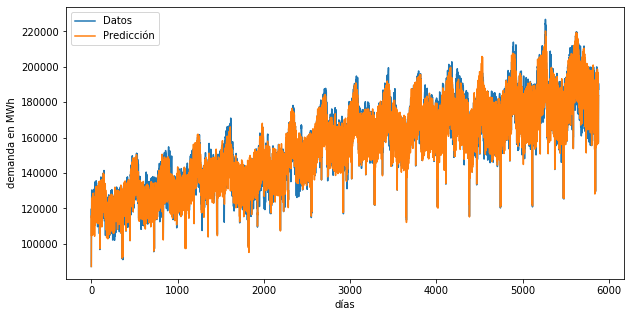

MAPE =  2.1142 %


In [119]:
plt.figure(figsize=(10,5))
plt.plot(onlyMWh.MWh[0:n].values,label ="Datos")
plt.plot(prediction,label="Predicción")
plt.ylabel("demanda en MWh")
plt.xlabel("días")
plt.legend()
plt.show()
#%%obtener mape de regresión
comp=comparacion(onlyMWh.MWh.values[:n],prediction)
MAPE=comp.error.mean()
print("MAPE = ",round(MAPE,4),"%")

### Graficar residuales de la regresión

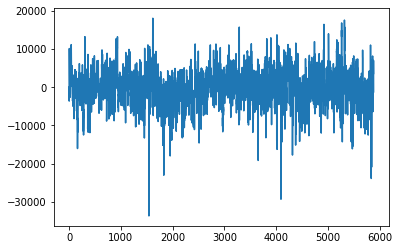

In [120]:
Tabla=pd.DataFrame(columns=['regresion','datos','resta'])
Tabla["regresion"]=prediction
Tabla["datos"]=onlyMWh.MWh[0:n].values
Tabla["resta"]=Tabla.datos-Tabla.regresion
plt.plot(Tabla.resta)
plt.show()

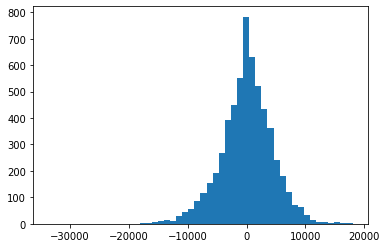

In [121]:
plt.hist(Tabla["resta"],bins=50)
plt.show()

In [122]:
resta=pd.DataFrame(Tabla["resta"])

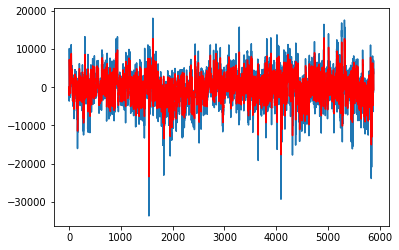

In [135]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(resta, order=(2,0,4))
results = mod.fit()
plt.plot(resta)
plt.plot(results.fittedvalues, color='red');

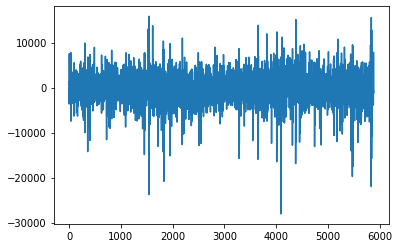

In [124]:
T=pd.DataFrame(columns=['regresion','datos','nuevo'])
T["regresion"]=results.fittedvalues
T["datos"]=resta
T["nuevo"]=T.datos-T.regresion
plt.plot(T.nuevo)
plt.show()

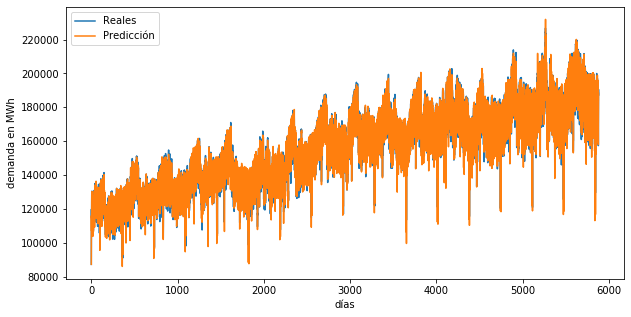

MAPE =  1.3677 %


In [125]:
##spatial electric load forecasting
plt.figure(figsize=(10,5))
plt.plot(onlyMWh.MWh[0:n].values,label="Reales")
plt.plot(prediction+results.fittedvalues,label="Predicción")
#plt.axis([1630,1650,120000,160000])
plt.ylabel("demanda en MWh")
plt.xlabel("días")
plt.legend()
plt.show()
#%%obtener mape de regresión
comp=comparacion(onlyMWh.MWh[0:n].values,prediction+results.fittedvalues)
MAPE=comp.error.mean()
print("MAPE = ",round(MAPE,4),"%")

### Gráfica de manera dinámica

In [126]:
extra=results.predict(len(onlyMWh.MWh[0:n]),len(onlyMWh.MWh[0:n])-n)
extra=extra.iloc[1:]

en vez de lasso XGBoost

In [139]:
from sklearn.model_selection import train_test_split

In [ ]:
def get_train_split_xgb(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 1/len(y_test), shuffle = False)
    return X_train, X_test, X_val, y_train, y_test, y_val 

In [ ]:
Combinaciontest=kronecker(sencos_test,Dum_test)

In [ ]:
fet_train_test_split_xgb()

In [127]:
from sklearn.linear_model import Lasso
Combinaciontest=kronecker(sencos_test,Dum_test)
#Initializing the Lasso Regressor with Normalization Factor as True
lasso_reg = Lasso(normalize=True)
#Fitting the Training data to the Lasso regressor
lasso_reg.fit(Combinacion,onlyMWh.MWh[0:n])
coeff = lasso_reg.coef_
#coeff
#Predicting for X_test
y_pred_lass =lasso_reg.predict(Combinaciontest)

In [128]:
coeff = np.sum(abs(lasso_reg.coef_)==0)
coeff

833

In [129]:
len(lasso_reg.coef_)

1064

In [130]:
#comb=Combinacion
#comb2=Combinaciontest
#x=np.where(lasso_reg.coef_==0)

In [131]:
#comb=comb.drop(comb.columns[x], axis=1)
#comb2=comb2.drop(comb2.columns[x], axis=1)

In [132]:
#from sklearn.linear_model import HuberRegressor
#huber = HuberRegressor().fit(comb,onlyMWh.MWh[0:n])
#hubpredict=huber.predict(comb2)

### todo para pronóstico

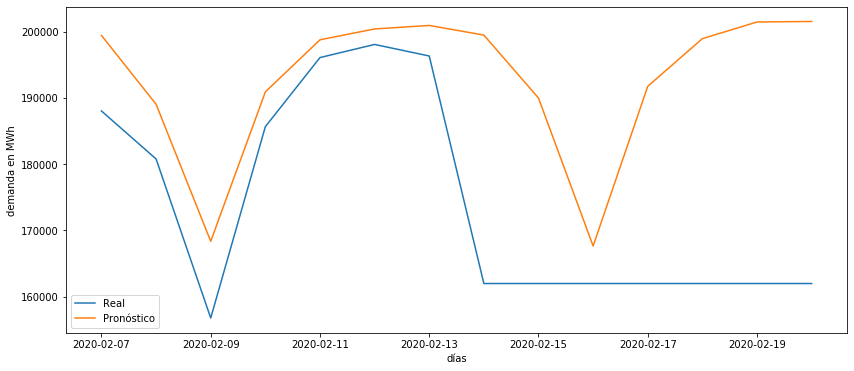

MAPE =  11.3976 %


In [133]:
comp_pronostico=comparacion(final,y_pred_lass+extra.values)
#comp_pronostico=comparacion(final,hubpredict+extra.values)
MAPE=comp_pronostico.error.mean()
plt.figure(figsize=(14,6))
plt.plot(final,label="Real")
plt.plot(comp_pronostico.prediccion,label="Pronóstico")
plt.ylabel("demanda en MWh")
plt.xlabel("días")
plt.legend()
plt.show()
print("MAPE = ",round(MAPE,4),"%")

In [134]:
comp_pronostico

,real,prediccion,error
fecha,,,
2020-02-07,188033.000000,199431.388223,6.061908
2020-02-08,180791.299362,189045.682354,4.565697
2020-02-09,156802.632000,168370.134422,7.377110
2020-02-10,185664.461000,190911.405502,2.826036
2020-02-11,196090.494000,198769.845784,1.366385
2020-02-12,198069.940000,200409.685301,1.181272
2020-02-13,196326.300497,200935.758455,2.347856
2020-02-14,162000.000000,199481.202807,23.136545
2020-02-15,162000.000000,189984.683030,17.274496


###  Hasta aqui

In [97]:
end = time.time()
print((end - start)/60)

8.409390457471211


In [98]:
model =LinearRegression()
model.fit(comb,onlyMWh.MWh[0:n])
prediction=model.predict(comb2)
comp_pronostico=comparacion(final,prediction+extra.values)
MAPE=comp_pronostico.error.mean()
plt.figure(figsize=(10,5))
plt.plot(final,label="Real")
plt.plot(comp_pronostico.prediccion,label="Pronóstico")
plt.ylabel("demanda en MWh")
plt.xlabel("días")
plt.legend()
plt.show()
print("MAPE = ",round(MAPE,4),"%")

NameError: name 'comb' is not defined

In [ ]:
comp_pronostico 799,39.39 58.39 13.01

In [ ]:
lasso_reg = Lasso(normalize=True)
#Fitting the Training data to the Lasso regressor
lasso_reg.fit(comb,onlyMWh.MWh[0:n])
coeff = lasso_reg.coef_
#coeff
#Predicting for X_test
y_pred_lass =lasso_reg.predict(comb2)
comp_pronostico=comparacion(final,y_pred_lass+extra.values)
MAPE=comp_pronostico.error.mean()
plt.figure(figsize=(10,5))
plt.plot(final,label="Real")
plt.plot(comp_pronostico.prediccion,label="Pronóstico")
plt.ylabel("demanda en MWh")
plt.xlabel("días")
plt.legend()
plt.show()
print("MAPE = ",round(MAPE,4),"%")

In [ ]:
#coeff = lasso_reg.coef_
#coeff